/tmp/ipykernel_31/4154464938.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Using device: cuda


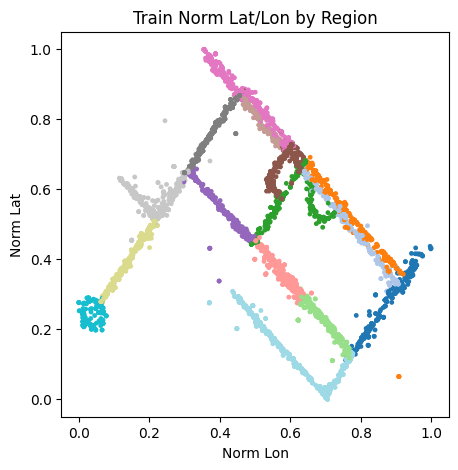

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Train Ep1:   0%|          | 0/203 [00:00<?, ?it/s]

/tmp/ipykernel_31/4154464938.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Ep1:   0%|          | 0/12 [00:00<?, ?it/s]

/tmp/ipykernel_31/4154464938.py:166: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): preds = model(imgs, meta).cpu().numpy()


Ep1: MSE(lat,lon)=228475.7,571485.2 | Avg=399980.4
✓ Saved epoch model & preds (Avg MSE=399980.4)
Ensemble upto Ep1: MSE(lat,lon)=40694574611431424.0,29348480048693248.0 | Avg=35021528403804160.0
✓ Saved ensemble model & preds (Avg MSE=35021528403804160.0)


Train Ep2:   0%|          | 0/203 [00:00<?, ?it/s]

Val Ep2:   0%|          | 0/12 [00:00<?, ?it/s]

Ep2: MSE(lat,lon)=117627.4,283198.3 | Avg=200412.9
✓ Saved epoch model & preds (Avg MSE=200412.9)
Ensemble upto Ep2: MSE(lat,lon)=40669715340722176.0,29251383723032576.0 | Avg=34960548458135552.0
✓ Saved ensemble model & preds (Avg MSE=34960548458135552.0)


Train Ep3:   0%|          | 0/203 [00:00<?, ?it/s]

Val Ep3:   0%|          | 0/12 [00:00<?, ?it/s]

Ep3: MSE(lat,lon)=65672.1,153190.4 | Avg=109431.2
✓ Saved epoch model & preds (Avg MSE=109431.2)
Ensemble upto Ep3: MSE(lat,lon)=40654674365251584.0,29241146668482560.0 | Avg=34947910516867072.0
✓ Saved ensemble model & preds (Avg MSE=34947910516867072.0)


Train Ep4:   0%|          | 0/203 [00:00<?, ?it/s]

Val Ep4:   0%|          | 0/12 [00:00<?, ?it/s]

Ep4: MSE(lat,lon)=36646.3,64948.1 | Avg=50797.2
✓ Saved epoch model & preds (Avg MSE=50797.2)
Ensemble upto Ep4: MSE(lat,lon)=40660330837180416.0,29238080061833216.0 | Avg=34949205449506816.0


Train Ep5:   0%|          | 0/203 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
# === 0. (If needed) install timm ===
# !pip install timm

import os
import torch
import torch.nn as nn
import timm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# === 1. Device & AMP ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = torch.cuda.amp.GradScaler()
print("Using device:", device)

# === 2. Paths ===
train_csv     = "/kaggle/input/smainewdataset/Phase_2_data/labels_train.csv"
val_csv       = "/kaggle/input/smainewdataset/Phase_2_data/labels_val.csv"
train_img_dir = "/kaggle/input/smainewdataset/Phase_2_data/images_train/images_train"
val_img_dir   = "/kaggle/input/smainewdataset/Phase_2_data/images_val/images_val"

# === 3. Load & filter ===
train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)

# Filter outliers in training set
train_df = train_df[
    train_df.latitude.between(200000, 230000) &
    train_df.longitude.between(140000, 150000)
].reset_index(drop=True)

# Exclude specific image IDs from validation set
exclude_ids = {95, 145, 146, 158, 159, 160, 161}
val_df = val_df[~val_df['filename'].apply(
    lambda fn: int(os.path.splitext(fn)[0].split('_')[-1]) in exclude_ids
)].reset_index(drop=True)

# === 4. Standardization stats ===
lat_mean, lat_std = train_df.latitude.mean(), train_df.latitude.std()
lon_mean, lon_std = train_df.longitude.mean(), train_df.longitude.std()
std_lat = lambda x: (x - lat_mean) / lat_std
denstd_lat = lambda x: x * lat_std + lat_mean
std_lon = lambda x: (x - lon_mean) / lon_std
denstd_lon = lambda x: x * lon_std + lon_mean

# === 5. Cyclic embeddings ===
def add_cyclic(df):
    # Grid cyclic for latitude/longitude
    df['lat_sin'] = np.sin(2 * np.pi * (df.latitude - train_df.latitude.min()) / (train_df.latitude.max() - train_df.latitude.min()))
    df['lat_cos'] = np.cos(2 * np.pi * (df.latitude - train_df.latitude.min()) / (train_df.latitude.max() - train_df.latitude.min()))
    df['lon_sin'] = np.sin(2 * np.pi * (df.longitude - train_df.longitude.min()) / (train_df.longitude.max() - train_df.longitude.min()))
    df['lon_cos'] = np.cos(2 * np.pi * (df.longitude - train_df.longitude.min()) / (train_df.longitude.max() - train_df.longitude.min()))
    # Time of day from HH:MM or HH:MM:SS
    parts = df.timestamp.str.split(':', expand=True).astype(float).fillna(0)
    hh, mm = parts[0], parts[1]
    df['minute_of_day'] = hh * 60 + mm
    df['time_sin'] = np.sin(2 * np.pi * df.minute_of_day / 1440)
    df['time_cos'] = np.cos(2 * np.pi * df.minute_of_day / 1440)
    # Placeholders for weekday/month cyclic (if date data available)
    df['wd_sin'], df['wd_cos'] = 0.0, 1.0
    df['mo_sin'], df['mo_cos'] = 0.0, 1.0
    return df

train_df = add_cyclic(train_df)
val_df   = add_cyclic(val_df)

# === 6. Sanity scatter ===
lat_n = (train_df.latitude - train_df.latitude.min()) / (train_df.latitude.max() - train_df.latitude.min())
lon_n = (train_df.longitude - train_df.longitude.min()) / (train_df.longitude.max() - train_df.longitude.min())
plt.figure(figsize=(5,5))
plt.scatter(lon_n, lat_n, c=train_df.Region_ID, s=6, cmap='tab20')
plt.xlabel('Norm Lon'); plt.ylabel('Norm Lat'); plt.title('Train Norm Lat/Lon by Region'); plt.show()

# === 7. Dataset w/ standardized targets ===
META = ['lat_sin','lat_cos','lon_sin','lon_cos','time_sin','time_cos','wd_sin','wd_cos','mo_sin','mo_cos']
class GeoDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row.filename)
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img) if self.transform else transforms.ToTensor()(img)
        meta = torch.from_numpy(row[META].to_numpy(dtype=np.float32))
        lat = torch.tensor(std_lat(row.latitude), dtype=torch.float32)
        lon = torch.tensor(std_lon(row.longitude), dtype=torch.float32)
        return img, meta, lat, lon, row.filename

# === 8. Augment + loaders ===
train_tf = transforms.Compose([
    transforms.Resize((224,224)), transforms.RandAugment(),
    transforms.RandomHorizontalFlip(), transforms.ColorJitter(0.3,0.3,0.2,0.1),
    transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)), transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
bs = 32
train_loader = DataLoader(GeoDataset(train_df, train_img_dir, train_tf), batch_size=bs, shuffle=True, num_workers=4)
val_loader   = DataLoader(GeoDataset(val_df,   val_img_dir,   val_tf), batch_size=bs, shuffle=False, num_workers=4)

# === 9. Fusion with ConvNeXt base ===
class FusionModel(nn.Module):
    def __init__(self, meta_dim=10):
        super().__init__()
        self.backbone = timm.create_model('convnext_base.fb_in22k', pretrained=True, num_classes=0, global_pool='avg')
        feat = self.backbone.num_features
        self.meta_net = nn.Sequential(
            nn.Linear(meta_dim,128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128,64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.5)
        )
        self.head = nn.Sequential(
            nn.Linear(feat+64,256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256,2)
        )
    def forward(self, x, m):
        f = self.backbone(x)
        g = self.meta_net(m)
        return self.head(torch.cat([f,g], dim=1))

# === 10. Train/Validate w/ OneCycleLR + Ensemble ===
def train_validate(model, train_loader, val_loader, epochs=100):
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=5e-4, epochs=epochs,
        steps_per_epoch=len(train_loader), pct_start=0.1, anneal_strategy='cos'
    )

    # Tracking
    best_mse = float('inf')
    best_ens_mse = float('inf')
    filenames = list(val_df.filename)
    ensemble_preds = {fn: [] for fn in filenames}

    model.to(device)
    for ep in range(1, epochs+1):
        model.train()
        for imgs, meta, lat, lon, _ in tqdm(train_loader, leave=False, desc=f'Train Ep{ep}'):
            imgs, meta, lat, lon = imgs.to(device), meta.to(device), lat.to(device), lon.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                out = model(imgs, meta)
                loss = 0.5*(criterion(out[:,0], lat) + criterion(out[:,1], lon))
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update()
            scheduler.step()

        # Validation
        model.eval()
        epoch_preds, epoch_trues = [], []
        with torch.no_grad():
            for imgs, meta, lat, lon, _ in tqdm(val_loader, leave=False, desc=f'Val Ep{ep}'):
                imgs, meta = imgs.to(device), meta.to(device)
                with torch.cuda.amp.autocast(): preds = model(imgs, meta).cpu().numpy()
                epoch_preds.append(preds)
                epoch_trues.append(np.stack([lat.numpy(), lon.numpy()], axis=1))
        preds = np.vstack(epoch_preds)
        trues = np.vstack(epoch_trues)
        lat_pred = denstd_lat(preds[:,0]); lon_pred = denstd_lon(preds[:,1])
        lat_true = trues[:,0]*lat_std + lat_mean
        lon_true = trues[:,1]*lon_std + lon_mean

        mse_lat = ((lat_pred - lat_true)**2).mean()
        mse_lon = ((lon_pred - lon_true)**2).mean()
        avg_mse = 0.5*(mse_lat + mse_lon)
        print(f'Ep{ep}: MSE(lat,lon)={mse_lat:.1f},{mse_lon:.1f} | Avg={avg_mse:.1f}')

        # Save best per-epoch
        if avg_mse < best_mse:
            best_mse = avg_mse
            torch.save(model.state_dict(), f'best_fusion.pth')
            pd.DataFrame({'filename':filenames,'latitude_pred':lat_pred,'longitude_pred':lon_pred})\
              .to_csv(f'preds_{best_mse:.1f}.csv', index=False)
            print(f'✓ Saved epoch model & preds (Avg MSE={best_mse:.1f})')

        # Update ensemble
        for i, fn in enumerate(filenames):
            ensemble_preds[fn].append([lat_pred[i], lon_pred[i]])
        ens_array = np.vstack([np.mean(ensemble_preds[fn], axis=0) for fn in filenames])
        ens_lat = denstd_lat(ens_array[:,0]); ens_lon = denstd_lon(ens_array[:,1])
        ens_mse_lat = ((ens_lat - lat_true)**2).mean()
        ens_mse_lon = ((ens_lon - lon_true)**2).mean()
        ens_avg_mse = 0.5*(ens_mse_lat + ens_mse_lon)
        print(f'Ensemble upto Ep{ep}: MSE(lat,lon)={ens_mse_lat:.1f},{ens_mse_lon:.1f} | Avg={ens_avg_mse:.1f}')

        # Save best ensemble
        if ens_avg_mse < best_ens_mse:
            best_ens_mse = ens_avg_mse
            torch.save(model.state_dict(), f'best_model_ens_epoch{ep}_{best_ens_mse:.1f}.pth')
            pd.DataFrame({'filename':filenames,'latitude_pred':ens_lat,'longitude_pred':ens_lon})\
              .to_csv(f'predictions_avg_{best_ens_mse:.1f}.csv', index=False)
            print(f'✓ Saved ensemble model & preds (Avg MSE={best_ens_mse:.1f})')

    print(f'Done. Best epoch MSE={best_mse:.1f}, Best ensemble MSE={best_ens_mse:.1f}')
    return best_mse, best_ens_mse

# === 11. Run ===
model = FusionModel(meta_dim=len(META))
best_epoch_mse, best_ensemble_mse = train_validate(model, train_loader, val_loader, epochs=50)
print('Final: Best Epoch Avg MSE=', best_epoch_mse, '| Best Ensemble Avg MSE=', best_ensemble_mse)
